In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat, savemat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from time import time

In [2]:
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/positive_cropped.mat"
mal_dict = loadmat(path)
infected = mal_dict['stack']
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/negative_cropped.mat"
wmal_dict = loadmat(path)
normal = wmal_dict['stack']
infected = np.moveaxis(infected, -1, 0)
normal = np.moveaxis(normal, -1, 0)

infected_train, infected_test = train_test_split(infected, test_size = 0.2)
normal_train, normal_test = train_test_split(normal, test_size = 0.2)
normal_train.shape

(580, 28, 28, 3)

In [3]:
def get_training_iterator(n = 0):
    infected_dataset = tf.data.Dataset.from_tensor_slices(infected_train//(n+1))
    normal_dataset = tf.data.Dataset.from_tensor_slices(normal_train//(n+1))
    
    if n > 0:
        infected_dataset = infected_dataset.shuffle(n+1).repeat().batch(1)
        normal_dataset1 = normal_dataset.shuffle(n+1).repeat().batch(n)
        dataset1 = tf.data.Dataset.zip((infected_dataset, normal_dataset1))
        dataset1 = dataset1.map(lambda x,y: (tf.cast(tf.reduce_sum(tf.concat([x, y], axis=0), axis=0), tf.uint8), [0,1]))
        dataset1 = dataset1.batch(16)
    else:
        dataset1 = infected_dataset.repeat().map(lambda x: (tf.cast(x, tf.uint8), [0,1]))
        dataset1 = dataset1.shuffle(17).batch(16)
    
    dataset0 = normal_dataset.shuffle(n+2).repeat().batch(n+1)
    dataset0 = dataset0.map(lambda x: (tf.cast(tf.reduce_sum(x, axis=0), tf.uint8), [1,0]))
    dataset0 = dataset0.batch(16)
    
    iterator0 = dataset0.make_initializable_iterator()
    iterator1 = dataset1.make_initializable_iterator()
    
    return iterator0, iterator1

def get_testing_iterator(n = 0):
    infected_dataset = tf.data.Dataset.from_tensor_slices(infected_test//(n+1))
    normal_dataset = tf.data.Dataset.from_tensor_slices(normal_test//(n+1))
    
    if n > 0:
        infected_dataset = infected_dataset.shuffle(n+1).repeat().batch(1)
        normal_dataset1 = normal_dataset.shuffle(n+1).repeat().batch(n)
        dataset1 = tf.data.Dataset.zip((infected_dataset, normal_dataset1))
        dataset1 = dataset1.map(lambda x,y: (tf.cast(tf.reduce_sum(tf.concat([x, y], axis=0), axis=0), tf.uint8), [0,1]))
        dataset1 = dataset1.batch(16)
    else:
        dataset1 = infected_dataset.repeat().map(lambda x: (tf.cast(x, tf.uint8), [0,1]))
        dataset1 = dataset1.shuffle(17).batch(16)
    
    dataset0 = normal_dataset.shuffle(n+2).repeat().batch(n+1)
    dataset0 = dataset0.map(lambda x: (tf.cast(tf.reduce_sum(x, axis=0), tf.uint8), [1,0]))
    dataset0 = dataset0.batch(16)
    
    iterator0 = dataset0.make_initializable_iterator()
    iterator1 = dataset1.make_initializable_iterator()
    
    return iterator0, iterator1

In [4]:
def get_batch(istrain):
    if istrain == 0:
        x0, y0 = train_it0.get_next()
        x1, y1 = train_it1.get_next()
        x = tf.cast(tf.concat([x0,x1], axis=0), tf.float32)
        x = tf.add(x, tf.random.normal(shape = tf.shape(x), 
                                       stddev=tf.math.sqrt(x*(1-1/(n+1)/numchannel)*256/pixel_well_depth)))
        y = tf.concat([y0,y1], axis=0)
    else:
        x0, y0 = test_it0.get_next()
        x1, y1 = test_it1.get_next()
        x = tf.cast(tf.concat([x0,x1], axis=0), tf.float32)
        x = tf.add(x, tf.random.normal(shape = tf.shape(x), 
                                       stddev=tf.math.sqrt(x*(1-1/(n+1)/numchannel)*256/pixel_well_depth)))
        y = tf.concat([y0,y1], axis=0)     
    return x, y

In [5]:
def pass_through_validation(sess, n = 0, numbatches = 50):
    val = 0
    for i in range(numbatches):
        val += sess.run(accuracy, feed_dict = {train_place: 1})
    return val/numbatches

In [6]:
def CNN2(net,labels,numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net #return net to examine accuracy

In [7]:
acc = list()
fulls = time()
for n in range(15):
    tf.reset_default_graph() 
    sess = tf.Session()
    pixel_well_depth = 20000
    numchannel = 3
    train_it0, train_it1 = get_training_iterator(n)
    test_it0, test_it1 = get_testing_iterator(n)
    train_place = tf.placeholder(tf.int8)
    images, label = get_batch(istrain=train_place)
    batch_size = 32
    pred = CNN2(images, label, 2)
    loss = tf.losses.softmax_cross_entropy(logits=pred, onehot_labels=label)
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
    prediction = tf.argmax(pred,1)
    truth = tf.argmax(label,1)
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction,truth)))
    
    Accuracy = list()
    for runs in range (5):
        sess.run(tf.global_variables_initializer())
        sess.run(train_it0.initializer)
        sess.run(train_it1.initializer)
        sess.run(test_it0.initializer)
        sess.run(test_it1.initializer)
        train_losses = list()
        val_losses = list()
        start=time()
        for i in range(251):
            _, tloss = sess.run([train_op, loss], feed_dict={train_place: 0})
            train_losses.append(tloss)
            if i%50==0:
                prediction = list()
                y_label = list()
                val_losses.append(pass_through_validation(sess, n, numbatches=20))
                print("iteration %d; batch classifier loss: %f; batch Validation accuracy: %f; Time passed in this loop: %.2f" % 
                      (i,train_losses[-1],val_losses[-1],time()-start))
        Accuracy.append(val_losses[-1])
    mean = sum(Accuracy)/5
    acc.append(Accuracy)
    sess.close()
fulle = time()

iteration 0; batch classifier loss: 1.065795; batch Validation accuracy: 0.503125; Time passed in this loop: 1.59
iteration 50; batch classifier loss: 0.158269; batch Validation accuracy: 0.996875; Time passed in this loop: 2.05
iteration 100; batch classifier loss: 0.010943; batch Validation accuracy: 0.996875; Time passed in this loop: 2.49
iteration 150; batch classifier loss: 0.001584; batch Validation accuracy: 1.000000; Time passed in this loop: 2.92
iteration 200; batch classifier loss: 0.000737; batch Validation accuracy: 1.000000; Time passed in this loop: 3.36
iteration 250; batch classifier loss: 0.000471; batch Validation accuracy: 1.000000; Time passed in this loop: 3.79
iteration 0; batch classifier loss: 0.785959; batch Validation accuracy: 0.500000; Time passed in this loop: 0.05
iteration 50; batch classifier loss: 0.009402; batch Validation accuracy: 0.996875; Time passed in this loop: 0.49
iteration 100; batch classifier loss: 0.019216; batch Validation accuracy: 0.9

iteration 250; batch classifier loss: 0.011494; batch Validation accuracy: 0.985938; Time passed in this loop: 2.37
iteration 0; batch classifier loss: 1.667645; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 50; batch classifier loss: 0.148921; batch Validation accuracy: 0.903125; Time passed in this loop: 0.53
iteration 100; batch classifier loss: 0.036144; batch Validation accuracy: 0.925000; Time passed in this loop: 0.99
iteration 150; batch classifier loss: 0.028277; batch Validation accuracy: 0.973437; Time passed in this loop: 1.46
iteration 200; batch classifier loss: 0.068458; batch Validation accuracy: 0.959375; Time passed in this loop: 1.92
iteration 250; batch classifier loss: 0.006569; batch Validation accuracy: 0.982812; Time passed in this loop: 2.39
iteration 0; batch classifier loss: 1.308998; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 50; batch classifier loss: 0.135879; batch Validation accuracy: 0.9

iteration 200; batch classifier loss: 0.044535; batch Validation accuracy: 0.973437; Time passed in this loop: 2.00
iteration 250; batch classifier loss: 0.021142; batch Validation accuracy: 0.984375; Time passed in this loop: 2.47
iteration 0; batch classifier loss: 0.846970; batch Validation accuracy: 0.500000; Time passed in this loop: 0.07
iteration 50; batch classifier loss: 0.391325; batch Validation accuracy: 0.845313; Time passed in this loop: 0.55
iteration 100; batch classifier loss: 0.158997; batch Validation accuracy: 0.932813; Time passed in this loop: 1.03
iteration 150; batch classifier loss: 0.111737; batch Validation accuracy: 0.954688; Time passed in this loop: 1.51
iteration 200; batch classifier loss: 0.027044; batch Validation accuracy: 0.979688; Time passed in this loop: 1.99
iteration 250; batch classifier loss: 0.046497; batch Validation accuracy: 0.985938; Time passed in this loop: 2.47
iteration 0; batch classifier loss: 0.804722; batch Validation accuracy: 0.

iteration 150; batch classifier loss: 0.057468; batch Validation accuracy: 0.950000; Time passed in this loop: 1.92
iteration 200; batch classifier loss: 0.096029; batch Validation accuracy: 0.932813; Time passed in this loop: 2.43
iteration 250; batch classifier loss: 0.026026; batch Validation accuracy: 0.960938; Time passed in this loop: 2.94
iteration 0; batch classifier loss: 0.790513; batch Validation accuracy: 0.500000; Time passed in this loop: 0.07
iteration 50; batch classifier loss: 0.477771; batch Validation accuracy: 0.789062; Time passed in this loop: 0.60
iteration 100; batch classifier loss: 0.268745; batch Validation accuracy: 0.854688; Time passed in this loop: 1.10
iteration 150; batch classifier loss: 0.087829; batch Validation accuracy: 0.932813; Time passed in this loop: 1.61
iteration 200; batch classifier loss: 0.114023; batch Validation accuracy: 0.967187; Time passed in this loop: 2.12
iteration 250; batch classifier loss: 0.142293; batch Validation accuracy: 

iteration 100; batch classifier loss: 0.474999; batch Validation accuracy: 0.807813; Time passed in this loop: 1.25
iteration 150; batch classifier loss: 0.285787; batch Validation accuracy: 0.800000; Time passed in this loop: 1.81
iteration 200; batch classifier loss: 0.227107; batch Validation accuracy: 0.934375; Time passed in this loop: 2.39
iteration 250; batch classifier loss: 0.141732; batch Validation accuracy: 0.945312; Time passed in this loop: 2.96
iteration 0; batch classifier loss: 0.927509; batch Validation accuracy: 0.500000; Time passed in this loop: 0.09
iteration 50; batch classifier loss: 0.582313; batch Validation accuracy: 0.817187; Time passed in this loop: 0.68
iteration 100; batch classifier loss: 0.267099; batch Validation accuracy: 0.801562; Time passed in this loop: 1.25
iteration 150; batch classifier loss: 0.228111; batch Validation accuracy: 0.853125; Time passed in this loop: 1.82
iteration 200; batch classifier loss: 0.098941; batch Validation accuracy: 

iteration 50; batch classifier loss: 0.630317; batch Validation accuracy: 0.706250; Time passed in this loop: 0.73
iteration 100; batch classifier loss: 0.463640; batch Validation accuracy: 0.745313; Time passed in this loop: 1.32
iteration 150; batch classifier loss: 0.293532; batch Validation accuracy: 0.885938; Time passed in this loop: 1.91
iteration 200; batch classifier loss: 0.097433; batch Validation accuracy: 0.915625; Time passed in this loop: 2.51
iteration 250; batch classifier loss: 0.082536; batch Validation accuracy: 0.895312; Time passed in this loop: 3.10
iteration 0; batch classifier loss: 1.115255; batch Validation accuracy: 0.500000; Time passed in this loop: 0.41
iteration 50; batch classifier loss: 0.653169; batch Validation accuracy: 0.604688; Time passed in this loop: 1.04
iteration 100; batch classifier loss: 0.576081; batch Validation accuracy: 0.759375; Time passed in this loop: 1.67
iteration 150; batch classifier loss: 0.390603; batch Validation accuracy: 0

iteration 0; batch classifier loss: 1.594806; batch Validation accuracy: 0.500000; Time passed in this loop: 0.14
iteration 50; batch classifier loss: 0.645468; batch Validation accuracy: 0.542188; Time passed in this loop: 0.78
iteration 100; batch classifier loss: 0.468585; batch Validation accuracy: 0.762500; Time passed in this loop: 1.40
iteration 150; batch classifier loss: 0.455815; batch Validation accuracy: 0.829688; Time passed in this loop: 2.05
iteration 200; batch classifier loss: 0.236271; batch Validation accuracy: 0.904687; Time passed in this loop: 2.69
iteration 250; batch classifier loss: 0.175335; batch Validation accuracy: 0.917188; Time passed in this loop: 3.32
iteration 0; batch classifier loss: 0.727810; batch Validation accuracy: 0.500000; Time passed in this loop: 0.12
iteration 50; batch classifier loss: 0.628027; batch Validation accuracy: 0.604688; Time passed in this loop: 0.78
iteration 100; batch classifier loss: 0.511054; batch Validation accuracy: 0.7

In [8]:
acc

[[1.0, 1.0, 1.0, 1.0, 1.0],
 [0.9953125, 0.996875, 1.0, 0.996875, 0.996875],
 [0.99375, 0.9859375, 0.9828125, 0.996875, 0.996875],
 [0.9609375, 0.9875, 0.9875, 0.990625, 0.975],
 [0.9671875, 0.9875, 0.9875, 0.984375, 0.9859375],
 [0.9671875, 0.9734375, 0.9515625, 0.965625, 0.984375],
 [0.9703125, 0.9796875, 0.9484375, 0.9125, 0.9640625],
 [0.9609375, 0.9609375, 0.9, 0.9375, 0.9671875],
 [0.9390625, 0.9640625, 0.9640625, 0.959375, 0.9234375],
 [0.9359375, 0.940625, 0.9453125, 0.9421875, 0.953125],
 [0.859375, 0.971875, 0.965625, 0.9359375, 0.9515625],
 [0.8953125, 0.9234375, 0.9375, 0.971875, 0.8953125],
 [0.903125, 0.8671875, 0.9453125, 0.953125, 0.9390625],
 [0.95625, 0.925, 0.959375, 0.903125, 0.95625],
 [0.959375, 0.9171875, 0.9421875, 0.90625, 0.925]]

In [12]:
fulle - fulls

255.60023760795593

Text(0, 0.5, 'accuracy')

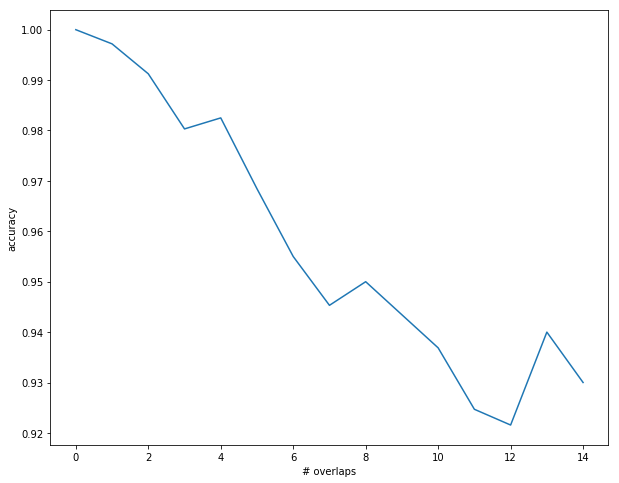

In [13]:
acc = np.mean(acc, axis=1)
plt.figure(figsize=(10,8))
plt.plot(acc)
plt.xlabel("# overlaps")
plt.ylabel("accuracy")

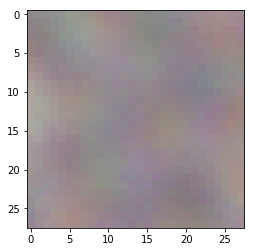

In [18]:
sess = tf.Session()
train_it0, train_it1 = get_training_iterator(n=4)
sess.run(tf.global_variables_initializer())
sess.run(train_it0.initializer)
sess.run(train_it1.initializer)
images, label = get_batch(istrain=0)
plt.imshow(sess.run(images)[14].astype(np.uint8))